[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alina-dima/nlp/blob/main/Machine_translation.ipynb)

In [1]:
!pip install datasets pandas seaborn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from datasets import load_dataset


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Load dataset

In [2]:
data = load_dataset("GroNLP/divemt")
print(data)
data["train"].to_pandas().head()
data_p = data["train"].to_pandas()

No config specified, defaulting to: divemt/main
Found cached dataset divemt (/Users/lisakoopmans/.cache/huggingface/datasets/GroNLP___divemt/main/1.0.0/c875a08adbd66d5d9c6d8c79f7816092829b41f855641161190c69e19b4f11b1)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['unit_id', 'flores_id', 'item_id', 'subject_id', 'lang_id', 'doc_id', 'task_type', 'translation_type', 'src_len_chr', 'mt_len_chr', 'tgt_len_chr', 'src_len_wrd', 'mt_len_wrd', 'tgt_len_wrd', 'edit_time', 'k_total', 'k_letter', 'k_digit', 'k_white', 'k_symbol', 'k_nav', 'k_erase', 'k_copy', 'k_cut', 'k_paste', 'k_do', 'n_pause_geq_300', 'len_pause_geq_300', 'n_pause_geq_1000', 'len_pause_geq_1000', 'event_time', 'num_annotations', 'last_modification_time', 'n_insert', 'n_delete', 'n_substitute', 'n_shift', 'tot_shifted_words', 'tot_edits', 'hter', 'cer', 'bleu', 'chrf', 'time_s', 'time_m', 'time_h', 'time_per_char', 'time_per_word', 'key_per_char', 'words_per_hour', 'words_per_minute', 'per_subject_visit_order', 'src_text', 'mt_text', 'tgt_text', 'aligned_edit', 'src_tokens', 'src_annotations', 'mt_tokens', 'mt_annotations', 'tgt_tokens', 'tgt_annotations', 'src_wmt22_qe', 'mt_wmt22_qe'],
        num_rows: 7740
    })
})


# Distribution of erros (bleu, chrf, cer) on the languages

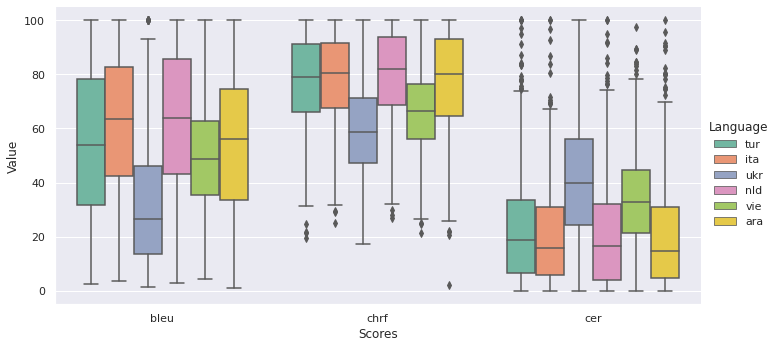

In [3]:
sns.set_theme()
data_p_copy = data_p.copy()
data_p_copy["cer"] = data_p["cer"]*100 # change the range of the cer score to 0 - 100
data_p_copy = data_p_copy.rename(columns={"lang_id": "Language"})
df_melted = pd.melt(data_p_copy, id_vars=["Language"], value_vars=["bleu", "chrf", "cer"], var_name="Scores", value_name="Value")

fig = sns.catplot(kind="box",data=pd.DataFrame(df_melted), x="Scores", y="Value", hue="Language", palette="Set2", height=5, aspect=2)

# Distribution of errors analysis based on the POS 
- computed as the number of BAD labels per POS category divided by number of words from that category

In [3]:
lang_ids = set(data_p["lang_id"])

# create a dict where the key is the language and the value is the dataset subset
data_p_pe = data_p.loc[data_p['task_type'] != "ht"].reset_index()
data_by_lang = {id : data_p.loc[data_p['lang_id'] == id].reset_index() for id in lang_ids}

This is done on the source setences

In [ ]:
def compute_pos_bad_rates(data_by_lang, lang, level="src"):
    counts_pos_src = {"ADJ": 0, "ADP": 0, "ADV": 0,  "AUX":0,  "CCONJ":0,  "DET":0 , "NOUN":0,  "NUM":0, "PART":0, "PRON":0, "PROPN":0, "PUNCT":0, "SCONJ":0, "SYM":0, "VERB":0, "X":0 }
    counts_bad_pos_src = {"ADJ": 0, "ADP": 0, "ADV": 0,  "AUX":0,  "CCONJ":0,  "DET":0 , "NOUN":0,  "NUM":0, "PART":0, "PRON":0, "PROPN":0, "PUNCT":0, "SCONJ":0, "SYM":0, "VERB":0, "X":0 }

    len_d = len(data_by_lang[lang]["src_annotations"])

    all_pos_src = [data_by_lang[lang][f"{level}_annotations"][i]["upos"] for i in range(len_d)]
    all_gb_src =  data_by_lang[lang][f"{level}_wmt22_qe"]

    for pos_list, gb_list in zip(all_pos_src, all_gb_src):
        for pos_value, gb_value in zip(pos_list, gb_list):
            counts_pos_src[pos_value] += 1 # count the words in that category
            counts_bad_pos_src[pos_value] += gb_value == "BAD" # count the wrongly translated words per category

    percents_bad_src = {k: float(counts_bad_pos_src[k])/counts_pos_src[k]  if counts_pos_src[k] != 0 else 0 for k in counts_bad_pos_src}
    return percents_bad_src


In [ ]:
# compute_pos_bad_rates(data_by_lang, 'ita', level="mt")

In [ ]:
bad_rates_by_lang_src = {}
bad_rates_by_lang_mt = {}
for lang in lang_ids:
    bad_rates_by_lang_src[lang] = compute_pos_bad_rates(data_by_lang, lang, level="src")
    # bad_rates_by_lang_mt[lang] = compute_pos_bad_rates(data_by_lang, lang, level="mt")

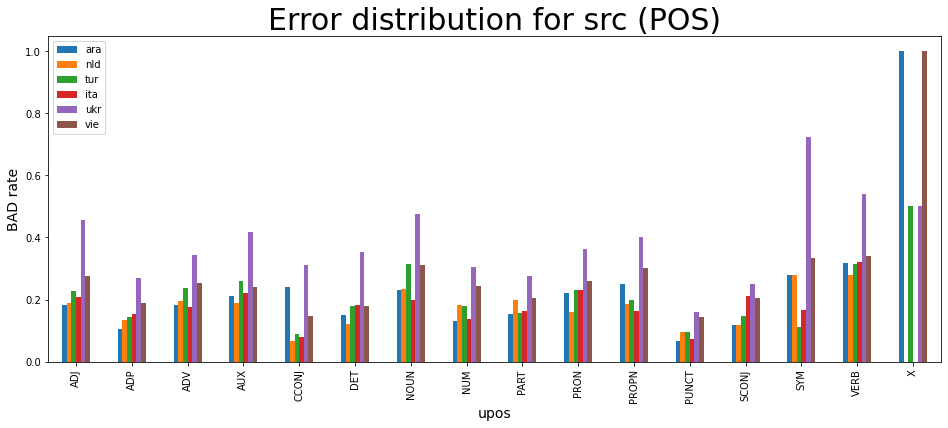

In [ ]:
def plot_all_languages(level="src"):
    to_use = bad_rates_by_lang_mt if level == "mt" else bad_rates_by_lang_src
    ax = pd.DataFrame(to_use).plot.bar(zorder=5, figsize=(16, 6))
    plt.title(f"Error distribution for {level} (POS)", fontsize=30)
    ax.set_xlabel("upos", fontsize=14)
    ax.set_ylabel("BAD rate", fontsize=14)
    plt.show()

plot_all_languages(level="src")
# plot_all_languages(level="mt")

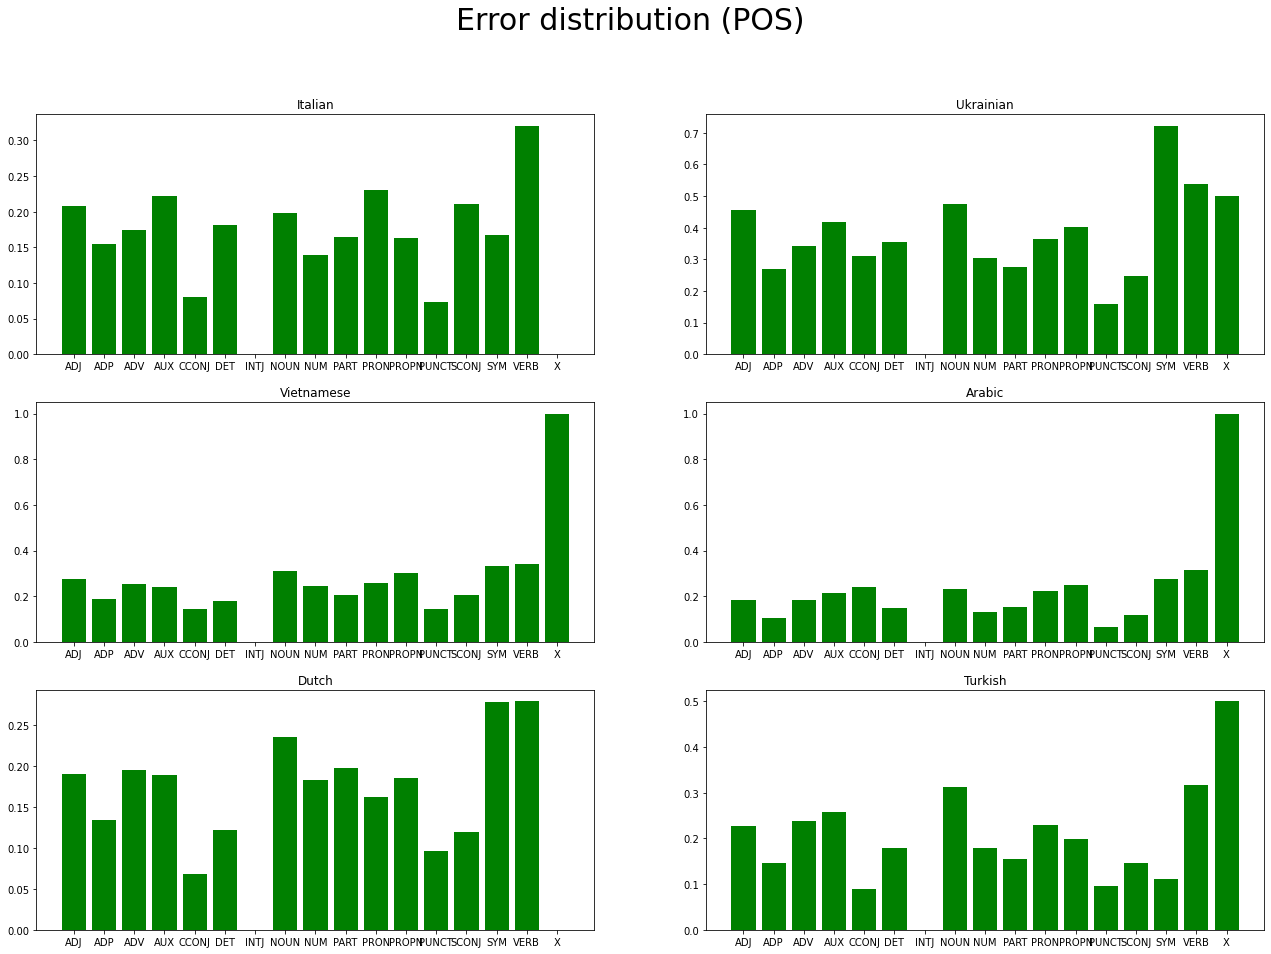

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools

fig, axs = plt.subplots(3, 2)
fig.suptitle("Error distribution (POS)", fontsize=30)
fig.set_size_inches(22, 15)
axs[0, 0].bar(list(bad_rates_by_lang['ita'].keys()), bad_rates_by_lang['ita'].values(), color='g')
axs[0, 0].set_title('Italian')
axs[0, 1].bar(list(bad_rates_by_lang['ukr'].keys()), bad_rates_by_lang['ukr'].values(), color='g')
axs[0, 1].set_title('Ukrainian')
axs[1, 0].bar(list(bad_rates_by_lang['vie'].keys()), bad_rates_by_lang['vie'].values(), color='g')
axs[1, 0].set_title('Vietnamese')
axs[1, 1].bar(list(bad_rates_by_lang['ara'].keys()), bad_rates_by_lang['ara'].values(), color='g')
axs[1, 1].set_title('Arabic')
axs[2, 0].bar(list(bad_rates_by_lang['nld'].keys()), bad_rates_by_lang['nld'].values(), color='g')
axs[2, 0].set_title('Dutch')
axs[2, 1].bar(list(bad_rates_by_lang['tur'].keys()), bad_rates_by_lang['tur'].values(), color='g')
axs[2, 1].set_title('Turkish')

# fig.add_axes("upos", fontsize=14)
# fig.set_ylabel("BAD rate", fontsize=14)
plt.show()

Interpretation: 30% of the nouns in the source sentences are not translated correctly in Turkish.

# Predict edit time based on error rate and sentence length

In [34]:
def get_mean_head_dist(data, level="src"):
    heads = data[f"{level}_annotations"]["head"]
    head_dists = np.asarray([abs(index - int(head)) for index, head in enumerate(heads)])
    return np.sum(head_dists)/len(heads)

def get_median_head_dist(data, level="src"):
    heads = data[f"{level}_annotations"]["head"]
    head_dists = np.asarray([abs(index - int(head)) for index, head in enumerate(heads)])
    return np.median(head_dists)


In [35]:
data_p_pe["src_bad_rate"] =  data_p_pe.apply(lambda x: np.count_nonzero(x["src_wmt22_qe"] == "BAD") / len(x["src_wmt22_qe"]), axis=1)
data_p_pe["mt_bad_rate"] =  data_p_pe.apply(lambda x: np.count_nonzero(x["mt_wmt22_qe"] == "BAD") / len(x["mt_wmt22_qe"]), axis=1)
data_p_pe["median_head_distance"] = data_p_pe.apply(get_median_head_dist, axis=1)
edit_time = data_p_pe["time_s"]
# predictors = data_p_pe[["src_len_wrd", "src_bad_rate"]]
predictors = data_p_pe[["src_len_wrd","src_bad_rate", "median_head_distance"]]

# OLS regression with more info
X2 = sm.add_constant(predictors)
est = sm.OLS(edit_time, X2)
est2 = est.fit()
print(est2.summary())

# Linear regression
reg = linear_model.LinearRegression().fit(predictors, edit_time)
print(reg.coef_)
print(reg.intercept_)

                            OLS Regression Results                            
Dep. Variable:                 time_s   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     46.95
Date:                Sat, 01 Apr 2023   Prob (F-statistic):           6.27e-30
Time:                        18:51:47   Log-Likelihood:                -37588.
No. Observations:                5160   AIC:                         7.518e+04
Df Residuals:                    5156   BIC:                         7.521e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -77.6395     17

# Distribution of errors analysis based on the NER 
- computed as the number of BAD labels per NER category divided by number of words from that category

In [ ]:
data_p = data["train"].to_pandas()
lang_ids = set(data_p["lang_id"])

# create a dict where the key is the language and the value is the dataset subset
data_p_pe = data_p.loc[data_p['task_type'] != "ht"].reset_index()
data_by_lang = {id : data_p.loc[data_p['lang_id'] == id].reset_index() for id in lang_ids}

This is done on the source setences

In [ ]:
def get_ner_types(data_by_lang, lang, level):
    ner_types = []
    len_d = len(data_by_lang[lang]["src_annotations"])
    all_ner = [data_by_lang[lang][f"{level}_annotations"][i]["ner"] for i in range(len_d)]
    for lst in all_ner:
        for item in lst:
            if item != "O" and item[2:] not in ner_types:
                ner_types.append(item[2:])
            elif item == "O" and item not in ner_types:
                ner_types.append(item)
    return ner_types

In [ ]:
def compute_ner_bad_rates(data_by_lang, lang, level="src"):
    len_d = len(data_by_lang[lang]["src_annotations"])
    all_ner_src = [data_by_lang[lang][f"{level}_annotations"][i]["ner"] for i in range(len_d)]
    
    ner_types = sorted(get_ner_types(data_by_lang, lang, level))
    counts_ner_src = {key: 0 for key in ner_types}
    counts_bad_ner_src = {key: 0 for key in ner_types}

    all_gb_src =  data_by_lang[lang][f"{level}_wmt22_qe"]

    for ner_list, gb_list in zip(all_ner_src, all_gb_src):
        for ner_value, gb_value in zip(ner_list, gb_list):
            if ner_value != "O":
                value = ner_value[2:]
            else:
                value = ner_value
            counts_ner_src[value] += 1 # count the words in that category
            counts_bad_ner_src[value] += gb_value == "BAD" # count the wrongly translated words per category

    percents_bad_src = {k: float(counts_bad_ner_src[k])/counts_ner_src[k]  if counts_ner_src[k] != 0 else 0 for k in counts_bad_ner_src}
    return percents_bad_src


In [ ]:
bad_rates_by_lang_src = {}
bad_rates_by_lang_mt = {}
for lang in lang_ids:
    bad_rates_by_lang_src[lang] = compute_ner_bad_rates(data_by_lang, lang, level="src")
    # bad_rates_by_lang_mt[lang] = compute_pos_bad_rates(data_by_lang, lang, level="mt")

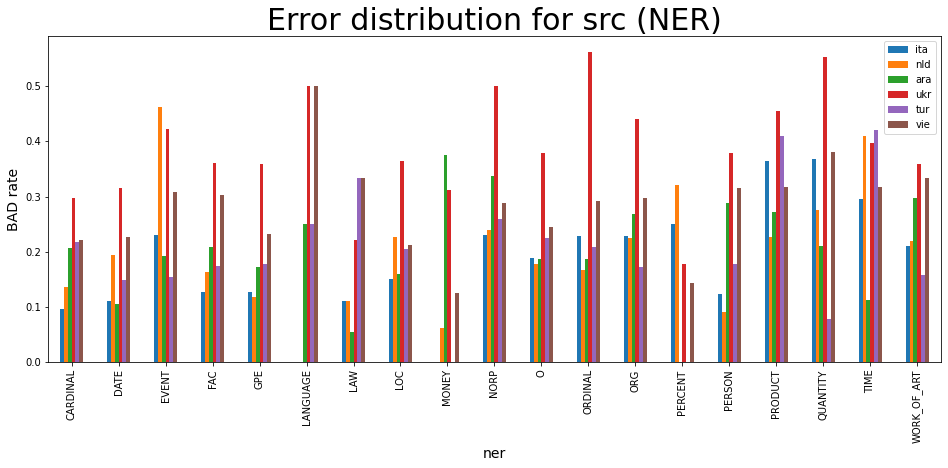

In [ ]:
def plot_all_languages(level="src"):
    to_use = bad_rates_by_lang_mt if level == "mt" else bad_rates_by_lang_src
    ax = pd.DataFrame(to_use).plot.bar(zorder=5, figsize=(16, 6))
    plt.title(f"Error distribution for {level} (NER)", fontsize=30)
    ax.set_xlabel("ner", fontsize=14)
    ax.set_ylabel("BAD rate", fontsize=14)
    plt.show()

plot_all_languages(level="src")
# plot_all_languages(level="mt")

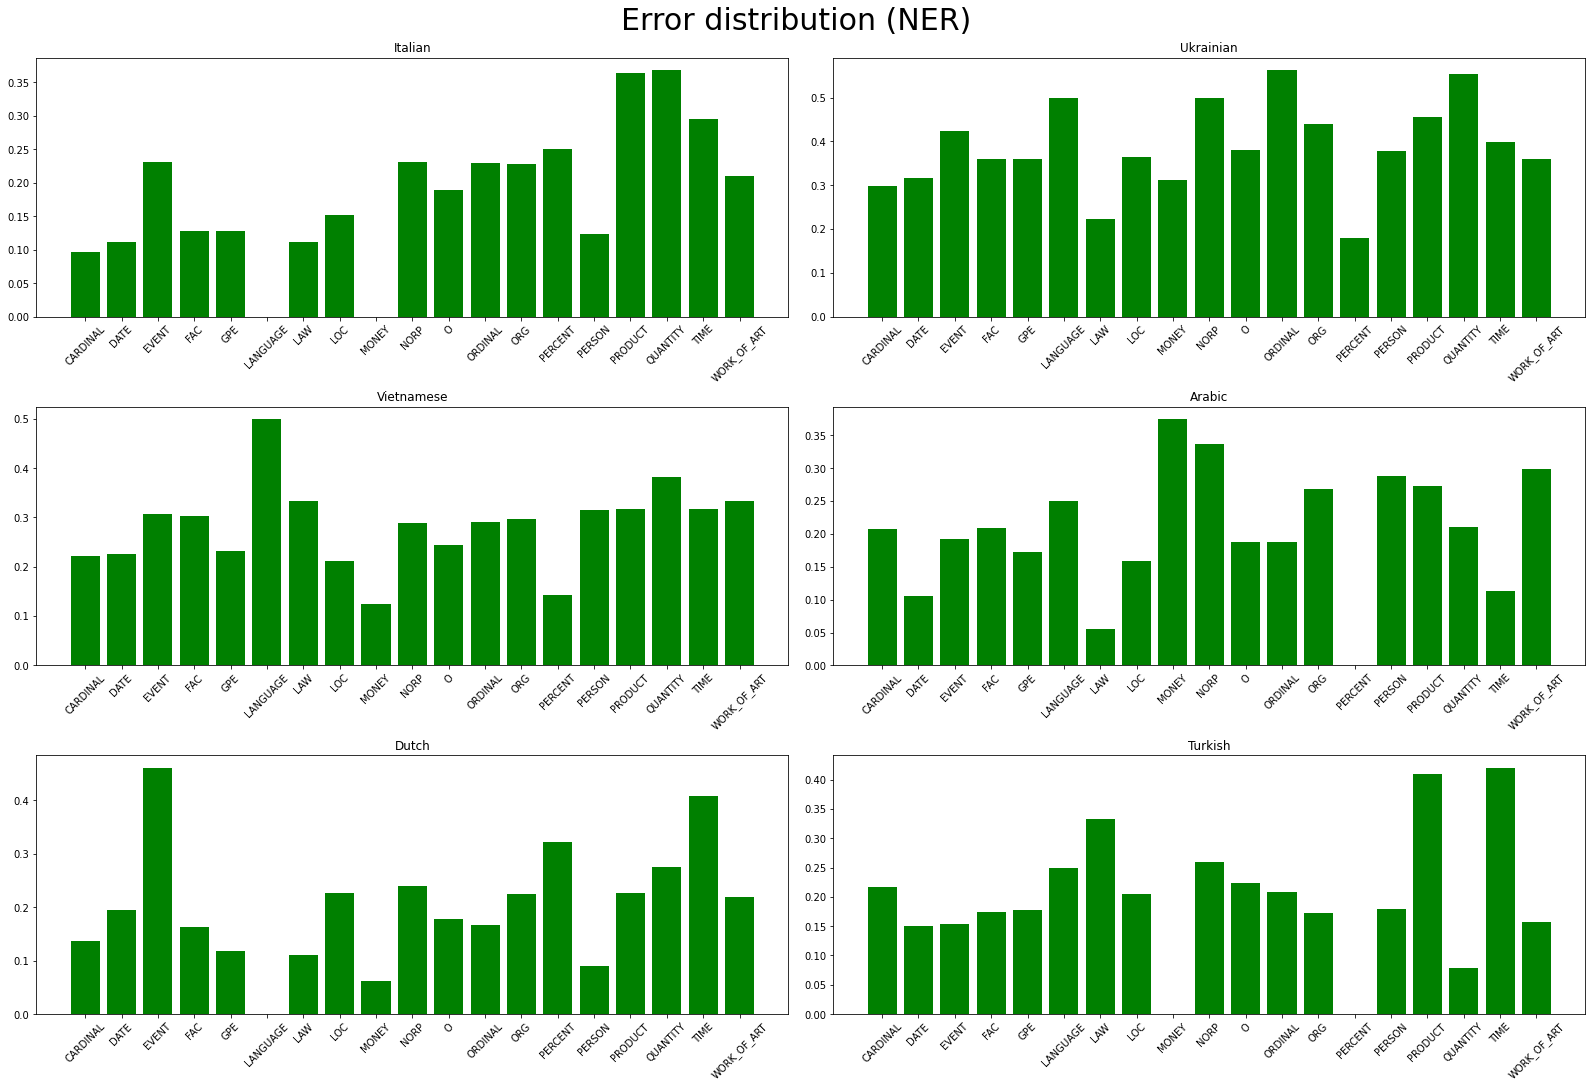

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools

fig, axs = plt.subplots(3, 2, constrained_layout = True)
fig.suptitle("Error distribution (NER)", fontsize=30)
fig.set_size_inches(22, 15)
label_rotation = 45

axs[0, 0].bar(list(bad_rates_by_lang_src['ita'].keys()), bad_rates_by_lang_src['ita'].values(), color='g')
axs[0, 0].set_title('Italian')
axs[0, 0].tick_params(axis='x', labelrotation = label_rotation)
axs[0, 1].bar(list(bad_rates_by_lang_src['ukr'].keys()), bad_rates_by_lang_src['ukr'].values(), color='g')
axs[0, 1].set_title('Ukrainian')
axs[0, 1].tick_params(axis='x', labelrotation = label_rotation)
axs[1, 0].bar(list(bad_rates_by_lang_src['vie'].keys()), bad_rates_by_lang_src['vie'].values(), color='g')
axs[1, 0].set_title('Vietnamese')
axs[1, 0].tick_params(axis='x', labelrotation = label_rotation)
axs[1, 1].bar(list(bad_rates_by_lang_src['ara'].keys()), bad_rates_by_lang_src['ara'].values(), color='g')
axs[1, 1].set_title('Arabic')
axs[1, 1].tick_params(axis='x', labelrotation = label_rotation)
axs[2, 0].bar(list(bad_rates_by_lang_src['nld'].keys()), bad_rates_by_lang_src['nld'].values(), color='g')
axs[2, 0].set_title('Dutch')
axs[2, 0].tick_params(axis='x', labelrotation = label_rotation)
axs[2, 1].bar(list(bad_rates_by_lang_src['tur'].keys()), bad_rates_by_lang_src['tur'].values(), color='g')
axs[2, 1].set_title('Turkish')
axs[2, 1].tick_params(axis='x', labelrotation = label_rotation)

plt.show()

# Distribution of errors analysis based on the dependency relations
- computed as the number of BAD labels per dependcy relation divided by number of words from that category

In [8]:
def get_deprel_cats(data_by_lang, lang, level):
    all_deprels = []
    
    len_d = len(data_by_lang[lang]["src_annotations"])
    all_pos_src = [data_by_lang[lang][f"{level}_annotations"][i]["deprel"] for i in range(len_d)]
    for lst in all_pos_src:
        for el in lst:
            all_deprels.append(el)
    return sorted(np.unique(all_deprels))

In [83]:
def compute_deprel_bad_rates(data_by_lang, lang, level="src"):
    deprel_cats = get_deprel_cats(data_by_lang, lang, level)
    counts_deprel_src = {key : 0 for key in deprel_cats}
    counts_deprel_bad_src = {key: 0 for key in deprel_cats}

    len_d = len(data_by_lang[lang]["src_annotations"])

    all_pos_src = [data_by_lang[lang][f"{level}_annotations"][i]["deprel"] for i in range(len_d)]
    all_gb_src =  data_by_lang[lang][f"{level}_wmt22_qe"]

    for dep_list, gb_list in zip(all_pos_src, all_gb_src):
        for dep_value, gb_value in zip(dep_list, gb_list):
            counts_deprel_src[dep_value] += 1 # count the words in that category
            counts_deprel_bad_src[dep_value] += gb_value == "BAD" # count the wrongly translated words per category

    # counts_median =np.median(np.asarray([value for k,value in list(counts_deprel_src.items())]))
    total_counts = np.sum(np.asarray([value for k,value in list(counts_deprel_src.items())]))
    total_bad_counts = np.sum(np.asarray([value for k, value in list(counts_deprel_bad_src.items())]))

    percents_src = {cat: float(counts_deprel_src[cat])/total_counts * 100 if counts_deprel_src[cat] >= 0 else 0 for cat in counts_deprel_src}

    percents_bad_src_norm = {k: float(counts_deprel_bad_src[k])/total_bad_counts  if percents_src[k] >= 0.5 else 0 for k in counts_deprel_bad_src}
    
    percents_bad_src_centered = {k: float(counts_deprel_bad_src[k])/counts_deprel_src[k]  if percents_src[k] >= 0.5 else 0 for k in counts_deprel_bad_src}
    mean_bad = np.median(np.asarray([value for k, value in list(percents_bad_src_centered.items())]))
    print(mean_bad, total_bad_counts/total_counts)
    for cat in percents_bad_src_centered:
        percents_bad_src_centered[cat] = percents_bad_src_centered[cat] - mean_bad if percents_bad_src_centered[cat] - mean_bad > 0 else 0
    return percents_bad_src_centered, percents_bad_src_norm, percents_src

In [21]:

# bad_rates_by_lang_src = {}
# bad_rates_by_lang_mt = {}
# counts = {}
# for lang in lang_ids:
#     bad_rates_by_lang_src[lang], counts[lang] = compute_deprel_bad_rates(data_by_lang, lang, level="src")
#     c = [value for k,value in list(counts[lang].items())]
#     print(np.median(c), np.min(c), np.max(c), len(c), np.sum(c), np.mean(c))

280.0 4 2286 41 20906 509.9024390243902
280.0 4 2286 41 20906 509.9024390243902
280.0 4 2286 41 20906 509.9024390243902
280.0 4 2286 41 20906 509.9024390243902
280.0 4 2286 41 20906 509.9024390243902
280.0 4 2286 41 20906 509.9024390243902


In [84]:
bad_rates_by_lang_src = {}
bad_rates_by_lang_mt = {}
bad_rates_by_lang_src_norm = {}
percents_src = {}
for lang in lang_ids:
    bad_rates_by_lang_src[lang], bad_rates_by_lang_src_norm[lang], percents_src[lang] = compute_deprel_bad_rates(data_by_lang, lang, level="src")

0.3404255319148936 0.37888644408303834
0.2185792349726776 0.24791925762938868
0.16720257234726688 0.18602315124844543
0.17820773930753564 0.22003252654740266
0.16666666666666666 0.1799961733473644
0.18478260869565216 0.18913230651487611


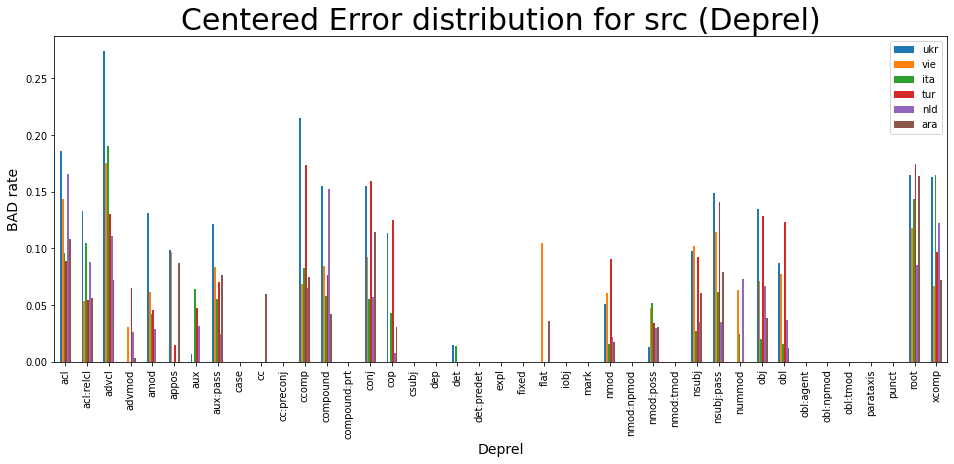

In [85]:
def plot_all_languages(level="src"):
    to_use = bad_rates_by_lang_mt if level == "mt" else bad_rates_by_lang_src
    ax = pd.DataFrame(to_use).plot.bar(zorder=5, figsize=(16, 6))
    plt.title(f"Centered Error distribution for {level} (Deprel)", fontsize=30)
    ax.set_xlabel("Deprel", fontsize=14)
    ax.set_ylabel("BAD rate", fontsize=14)
    plt.show()

plot_all_languages(level="src")

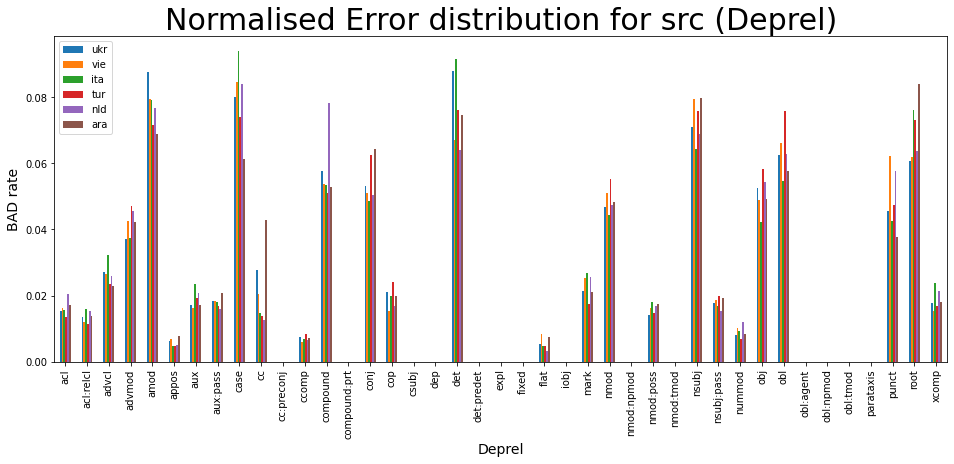

In [86]:
def plot_all_languages(level="src"):
    to_use = bad_rates_by_lang_mt if level == "mt" else bad_rates_by_lang_src_norm
    ax = pd.DataFrame(to_use).plot.bar(zorder=5, figsize=(16, 6))
    plt.title(f"Normalised Error distribution for {level} (Deprel)", fontsize=30)
    ax.set_xlabel("Deprel", fontsize=14)
    ax.set_ylabel("BAD rate", fontsize=14)
    plt.show()

plot_all_languages(level="src")
# how much each category contributed to the overall error rate

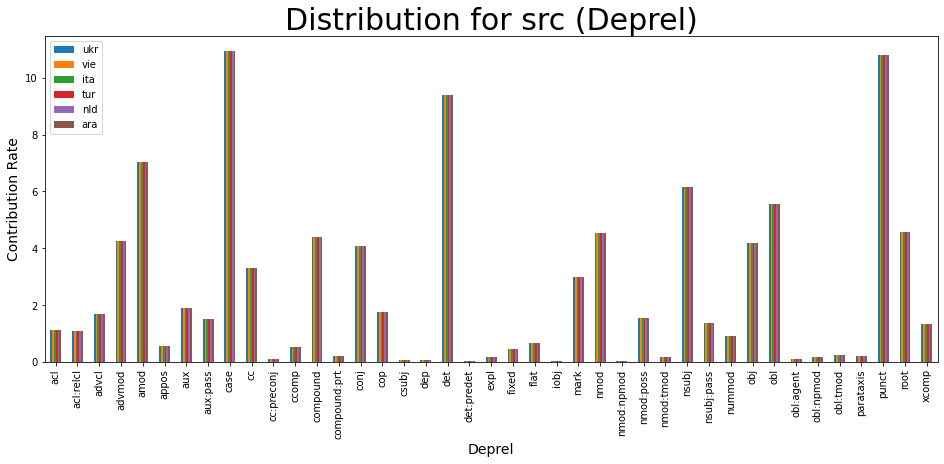

In [87]:
def plot_all_languages(level="src"):
    to_use = bad_rates_by_lang_mt if level == "mt" else percents_src
    ax = pd.DataFrame(to_use).plot.bar(zorder=5, figsize=(16, 6))
    plt.title(f"Distribution for {level} (Deprel)", fontsize=30)
    ax.set_xlabel("Deprel", fontsize=14)
    ax.set_ylabel("Contribution Rate", fontsize=14)
    plt.show()

plot_all_languages(level="src")

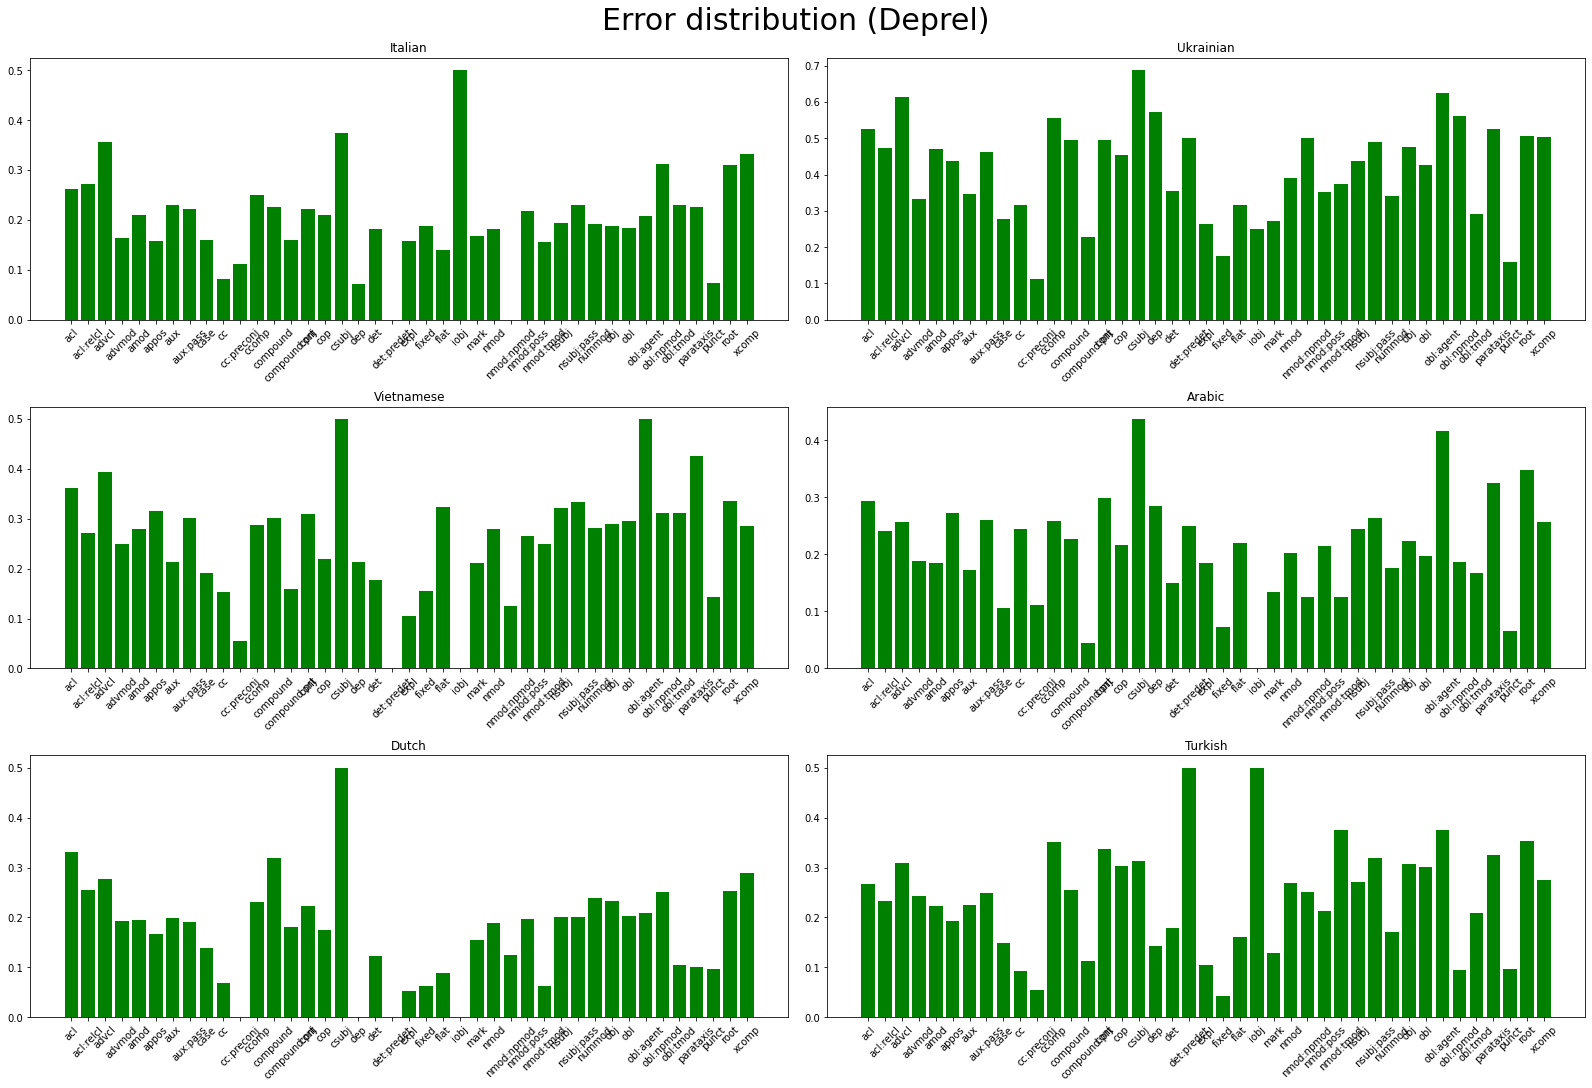

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools

fig, axs = plt.subplots(3, 2, constrained_layout = True)
fig.suptitle("Error distribution (Deprel)", fontsize=30)
fig.set_size_inches(22, 15)
label_rotation = 45

axs[0, 0].bar(list(bad_rates_by_lang_src['ita'].keys()), bad_rates_by_lang_src['ita'].values(), color='g')
axs[0, 0].set_title('Italian')
axs[0, 0].tick_params(axis='x', labelrotation = label_rotation)
axs[0, 1].bar(list(bad_rates_by_lang_src['ukr'].keys()), bad_rates_by_lang_src['ukr'].values(), color='g')
axs[0, 1].set_title('Ukrainian')
axs[0, 1].tick_params(axis='x', labelrotation = label_rotation)
axs[1, 0].bar(list(bad_rates_by_lang_src['vie'].keys()), bad_rates_by_lang_src['vie'].values(), color='g')
axs[1, 0].set_title('Vietnamese')
axs[1, 0].tick_params(axis='x', labelrotation = label_rotation)
axs[1, 1].bar(list(bad_rates_by_lang_src['ara'].keys()), bad_rates_by_lang_src['ara'].values(), color='g')
axs[1, 1].set_title('Arabic')
axs[1, 1].tick_params(axis='x', labelrotation = label_rotation)
axs[2, 0].bar(list(bad_rates_by_lang_src['nld'].keys()), bad_rates_by_lang_src['nld'].values(), color='g')
axs[2, 0].set_title('Dutch')
axs[2, 0].tick_params(axis='x', labelrotation = label_rotation)
axs[2, 1].bar(list(bad_rates_by_lang_src['tur'].keys()), bad_rates_by_lang_src['tur'].values(), color='g')
axs[2, 1].set_title('Turkish')
axs[2, 1].tick_params(axis='x', labelrotation = label_rotation)

plt.show()

In [ ]:
!pip install openkiwi
import kiwi


In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --config python3
!sudo apt install python3-pip

In [ ]:
!pip install --upgrade setuptools


In [ ]:
!pip install openkiwi

In [ ]:
import kiwi